# Covid 19 Predictors Analysis - Preprocessing Pipeline and Model

1. Rename and filter columns.
2. Drop rows containing absent values (4968 rows).
3. Drop class 4.
4. Combine classes for binary classification.
5. Extract train/test split (dropping ages of only 1 member).
6. Remap binary features (2 -> 0) for interpretability. For the `pregancy` column, maintain 3 values (1 = Yes, 0 = No) and remap 97 -> 2 (N/A).

In [1]:
import pandas as pd
from pathlib import Path
from shared import load_csv

df = load_csv()

## 1. Rename and Filter Columns

In [2]:
from shared import translate_filter_columns

df, col_names = translate_filter_columns(df)

## 2 & 3. Drop Rows with Absent Values, Drop Class 4

In [3]:
import numpy as np

df = df.replace([98, 99], np.nan).dropna()
df[df.isnull().any(axis=1)]

,sex,pneumonia,age,pregnant,diabetes,copd,asthma,immunosuppressed,hypertension,other_comorbidity,cardiovascular_disease,obesity,chronic_kidney_disease,smoking,contact_with_covid_case,covid_classification


In [4]:
df = df[df["covid_classification"] != 4]
df[df["covid_classification"] == 4]

,sex,pneumonia,age,pregnant,diabetes,copd,asthma,immunosuppressed,hypertension,other_comorbidity,cardiovascular_disease,obesity,chronic_kidney_disease,smoking,contact_with_covid_case,covid_classification


## 4. Combine Labels

Coupled with the findings from the preprocessing analysis, training a multiclass classifier (code not present in this notebook) revealed a few extra details with regards to the meaning of the class labels:

- Classes 3 and 5 were never predicted, the model naturally grouped all COVID positive cases into class 7. This seemed to indicate that bio-data and comorbidity features were not enough alone to distinguish between what I had guessed to all be positive diagnosis (just of different types somehow); they all shared very similar patterns.
- The model _did_ successfully separates COVID negative (class 6) from positive cases, which also treated positive labels as indistinguishable.

Conclusions:

- Let's combine classes 3, 5, and 7 into the COVID positive class (1), with class 6 as COVID negative (0).

In [5]:
df["covid_classification"] = df["covid_classification"].replace({3: 1, 5: 1, 7: 1, 6: 0})
df["covid_classification"].value_counts()

covid_classification
1    78104
0    46049
Name: count, dtype: int64

## 5. Produce Train/Test Split, Extract Labels

In [6]:
from sklearn.model_selection import train_test_split

# first, drop strata with less than 2 rows (only 3 instances)
counts = df["age"].value_counts()
mask = df["age"].isin(counts[counts > 1].index)
df = df[mask]

strat_train_set, strat_test_set = train_test_split(
    df, test_size=0.2, stratify=df["age"])

train_set = strat_train_set.drop("covid_classification", axis=1)
train_set_labels = strat_train_set["covid_classification"].copy()

test_set = strat_test_set.drop("covid_classification", axis=1)
test_set_labels = strat_test_set["covid_classification"].copy()

In [7]:
train_set.head()

,sex,pneumonia,age,pregnant,diabetes,copd,asthma,immunosuppressed,hypertension,other_comorbidity,cardiovascular_disease,obesity,chronic_kidney_disease,smoking,contact_with_covid_case
50309,2,2,0.0,97.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
105651,2,2,17.0,97.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
58029,2,2,17.0,97.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
110545,1,2,12.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
40306,1,2,34.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [8]:
train_set_labels.value_counts()

covid_classification
1    62471
0    36849
Name: count, dtype: int64

## 6. Re-encode Features

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

def remap_bin(X):
    """
    Remap binary features (2.0 -> 1.0)
    """
    return X.replace(2.0, 0.0)

def remap_preg(X):
    """
    Call remap_bin,
    Remap pregnancy N/A (97.0 -> 2.0)
    """
    return remap_bin(X).replace(97.0, 2.0)

# function transformers for binary features and pregnancy
bin_transformer = FunctionTransformer(remap_bin, feature_names_out=lambda t, fn: [name + "_remapped" for name in fn])
preg_transformer = FunctionTransformer(remap_preg, feature_names_out=lambda t, fn: [fn[0] + "_remapped"])

# main column transformer
binary_features = [
        "sex", "pneumonia", "diabetes", 
        "copd", "asthma", "immunosuppressed", "hypertension", "other_comorbidity", 
        "cardiovascular_disease", "obesity", "chronic_kidney_disease", "smoking", "contact_with_covid_case", 
    ]

preprocessing = ColumnTransformer([
    ("bin", bin_transformer, binary_features),
    ("preg", preg_transformer, ["pregnant"])
], remainder="passthrough")

train_set_prepared = preprocessing.fit_transform(train_set)

In [10]:
df_reconstructed = pd.DataFrame(
    train_set_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=train_set.index
)

# all column values mapped properly, just age showing.
df_reconstructed.columns[~df_reconstructed.isin([0.0, 1.0, 2.0]).all()]

Index(['remainder__age'], dtype='object')

In [11]:
preprocessing.get_feature_names_out()

array(['bin__sex_remapped', 'bin__pneumonia_remapped',
       'bin__diabetes_remapped', 'bin__copd_remapped',
       'bin__asthma_remapped', 'bin__immunosuppressed_remapped',
       'bin__hypertension_remapped', 'bin__other_comorbidity_remapped',
       'bin__cardiovascular_disease_remapped', 'bin__obesity_remapped',
       'bin__chronic_kidney_disease_remapped', 'bin__smoking_remapped',
       'bin__contact_with_covid_case_remapped', 'preg__pregnant_remapped',
       'remainder__age'], dtype=object)

## Modelling

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

tree_clf = make_pipeline(preprocessing, DecisionTreeClassifier(random_state=42))
tree_clf.fit(train_set, train_set_labels)

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bin', ...), ('preg', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
from sklearn.metrics import accuracy_score

# train set accuracy
train_set_predictions = tree_clf.predict(train_set)
train_accuracy = accuracy_score(train_set_labels, train_set_predictions)
train_accuracy

0.7234494563028594

In [14]:
# test set accuracy
test_set_predictions = tree_clf.predict(test_set)
test_accuracy = accuracy_score(test_set_labels, test_set_predictions)
test_accuracy

0.675795408779702

Let's assess multiple cross validation metrics arcoss 10 folds of the training set using sklearn's `cross_validate`.

In [15]:
from sklearn.model_selection import cross_validate

folds = 10
scoring = ["accuracy", "f1_weighted", "precision_weighted", "recall_weighted"]

tree_scores = cross_validate(
    estimator=tree_clf,
    X=train_set,
    y=train_set_labels,
    scoring=scoring,
    cv=folds,
    error_score="raise"
)

print(f"Metrics: {tree_scores.keys()}")

for metric in scoring:
    print(f"\n {metric}")
    scores = tree_scores[f"test_{metric}"]
    print(pd.Series(scores).describe())

Metrics: dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1_weighted', 'test_precision_weighted', 'test_recall_weighted'])

 accuracy
count    10.000000
mean      0.676843
std       0.004201
min       0.672473
25%       0.673429
50%       0.675896
75%       0.679798
max       0.685159
dtype: float64

 f1_weighted
count    10.000000
mean      0.681859
std       0.004125
min       0.677722
25%       0.678448
50%       0.680831
75%       0.684615
max       0.690133
dtype: float64

 precision_weighted
count    10.000000
mean      0.697738
std       0.004310
min       0.693549
25%       0.694102
50%       0.697072
75%       0.698832
max       0.706835
dtype: float64

 recall_weighted
count    10.000000
mean      0.676843
std       0.004201
min       0.672473
25%       0.673429
50%       0.675896
75%       0.679798
max       0.685159
dtype: float64


Hmm, not great. Let's try a random forest next.

In [16]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = make_pipeline(
    preprocessing, 
    RandomForestClassifier(
        random_state=42, 
        n_estimators=200)
)
forest_clf.fit(train_set, train_set_labels)

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bin', ...), ('preg', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
# train set accuracy
train_set_predictions = forest_clf.predict(train_set)
train_accuracy = accuracy_score(train_set_labels, train_set_predictions)

# test set accuracy
test_set_predictions = forest_clf.predict(test_set)
test_accuracy = accuracy_score(test_set_labels, test_set_predictions)

print(f"Train set accuracy: {train_accuracy}, Test set accuracy: {test_accuracy}")

Train set accuracy: 0.7234293193717277, Test set accuracy: 0.6834071687474829


Let's try to optimise the hyperparameters of this model!

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    "randomforestclassifier__n_estimators": [200, 300],
    "randomforestclassifier__max_depth": [15, 20, None],
    "randomforestclassifier__min_samples_leaf": [2, 4, 8],
    "randomforestclassifier__class_weight": [None, 'balanced']
}]

folds = 2

grid_search = GridSearchCV(
    estimator=forest_clf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=folds,
    verbose=2, # show computation time for each fold and parameter candidate, with scores
)
grid_search.fit(train_set, train_set_labels)

In [19]:
print(grid_search.best_params_)
best_forest = grid_search.best_estimator_
best_forest

{'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__n_estimators': 300}


,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bin', ...), ('preg', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [22]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# change column names
cv_res = cv_res[[
    "param_randomforestclassifier__class_weight",
    "param_randomforestclassifier__max_depth",
    "param_randomforestclassifier__min_samples_leaf",
    "param_randomforestclassifier__n_estimators",
    "mean_test_score"]]
cv_res.columns = ["class_weight", "max_depth", "min_samples_leaf", "n_estimators", "mean_test_score"]
print(cv_res.head())

  class_weight max_depth  min_samples_leaf  n_estimators  mean_test_score
5         None        15                 8           300         0.696416
2         None        15                 4           200         0.696255
4         None        15                 8           200         0.696023
3         None        15                 4           300         0.695560
1         None        15                 2           300         0.695449


In [25]:
from sklearn.metrics import classification_report

test_set_pred = best_forest.predict(test_set)
print(classification_report(test_set_labels, test_set_pred))

              precision    recall  f1-score   support

           0       0.58      0.63      0.61      9199
           1       0.77      0.73      0.75     15631

    accuracy                           0.69     24830
   macro avg       0.68      0.68      0.68     24830
weighted avg       0.70      0.69      0.70     24830



## Feature Importance Analysis

Training and test set accuracy for both the decision tree and random forest have plateaued around 70%. With only marginal difference in predictive accuracy between the two models, I'm guessing this feature set is not rich or diverse enough to push the ceiling any futher. That's okay, the goal of this notebook was to find important feature combinations; how bio-data and patient conditions rank relatively in COVID diagnosis (that is, the relative importance and interactions between these features).

These combinations will help in constructing symbolic rules in Prolog.

In [38]:
relative_feature_importance_forest = best_forest["randomforestclassifier"].feature_importances_ 
sorted(zip(relative_feature_importance_forest, best_forest["columntransformer"].get_feature_names_out()), reverse=True)

[(np.float64(0.5537207115273456), 'bin__pneumonia_remapped'),
 (np.float64(0.17023870645507466), 'remainder__age'),
 (np.float64(0.047212884707119436), 'bin__other_comorbidity_remapped'),
 (np.float64(0.04076822097389751), 'bin__immunosuppressed_remapped'),
 (np.float64(0.02743727134646695), 'bin__chronic_kidney_disease_remapped'),
 (np.float64(0.024090334724511647), 'bin__hypertension_remapped'),
 (np.float64(0.023372658067394008), 'bin__asthma_remapped'),
 (np.float64(0.023360910674564615), 'bin__contact_with_covid_case_remapped'),
 (np.float64(0.022111426439681833), 'bin__diabetes_remapped'),
 (np.float64(0.018634721602372027), 'bin__copd_remapped'),
 (np.float64(0.01743643666571191), 'preg__pregnant_remapped'),
 (np.float64(0.012805139244971541), 'bin__cardiovascular_disease_remapped'),
 (np.float64(0.007822243925550995), 'bin__smoking_remapped'),
 (np.float64(0.006984201380574785), 'bin__sex_remapped'),
 (np.float64(0.004004132264762541), 'bin__obesity_remapped')]

In [39]:
relative_feature_importance_tree = tree_clf["decisiontreeclassifier"].feature_importances_
sorted(zip(relative_feature_importance_tree, tree_clf["columntransformer"].get_feature_names_out()), reverse=True)

[(np.float64(0.4668735418813999), 'bin__pneumonia_remapped'),
 (np.float64(0.2348886078925913), 'remainder__age'),
 (np.float64(0.03877379198224783), 'bin__other_comorbidity_remapped'),
 (np.float64(0.02869999025624514), 'bin__immunosuppressed_remapped'),
 (np.float64(0.025392446059868505), 'preg__pregnant_remapped'),
 (np.float64(0.024717306707503245), 'bin__hypertension_remapped'),
 (np.float64(0.02469815154665787), 'bin__contact_with_covid_case_remapped'),
 (np.float64(0.024272459513983075), 'bin__chronic_kidney_disease_remapped'),
 (np.float64(0.02354182170190952), 'bin__asthma_remapped'),
 (np.float64(0.02252377567109557), 'bin__obesity_remapped'),
 (np.float64(0.01954204075802266), 'bin__diabetes_remapped'),
 (np.float64(0.01851685165365072), 'bin__sex_remapped'),
 (np.float64(0.017276256133464125), 'bin__smoking_remapped'),
 (np.float64(0.01570699047548794), 'bin__cardiovascular_disease_remapped'),
 (np.float64(0.014575967765872621), 'bin__copd_remapped')]

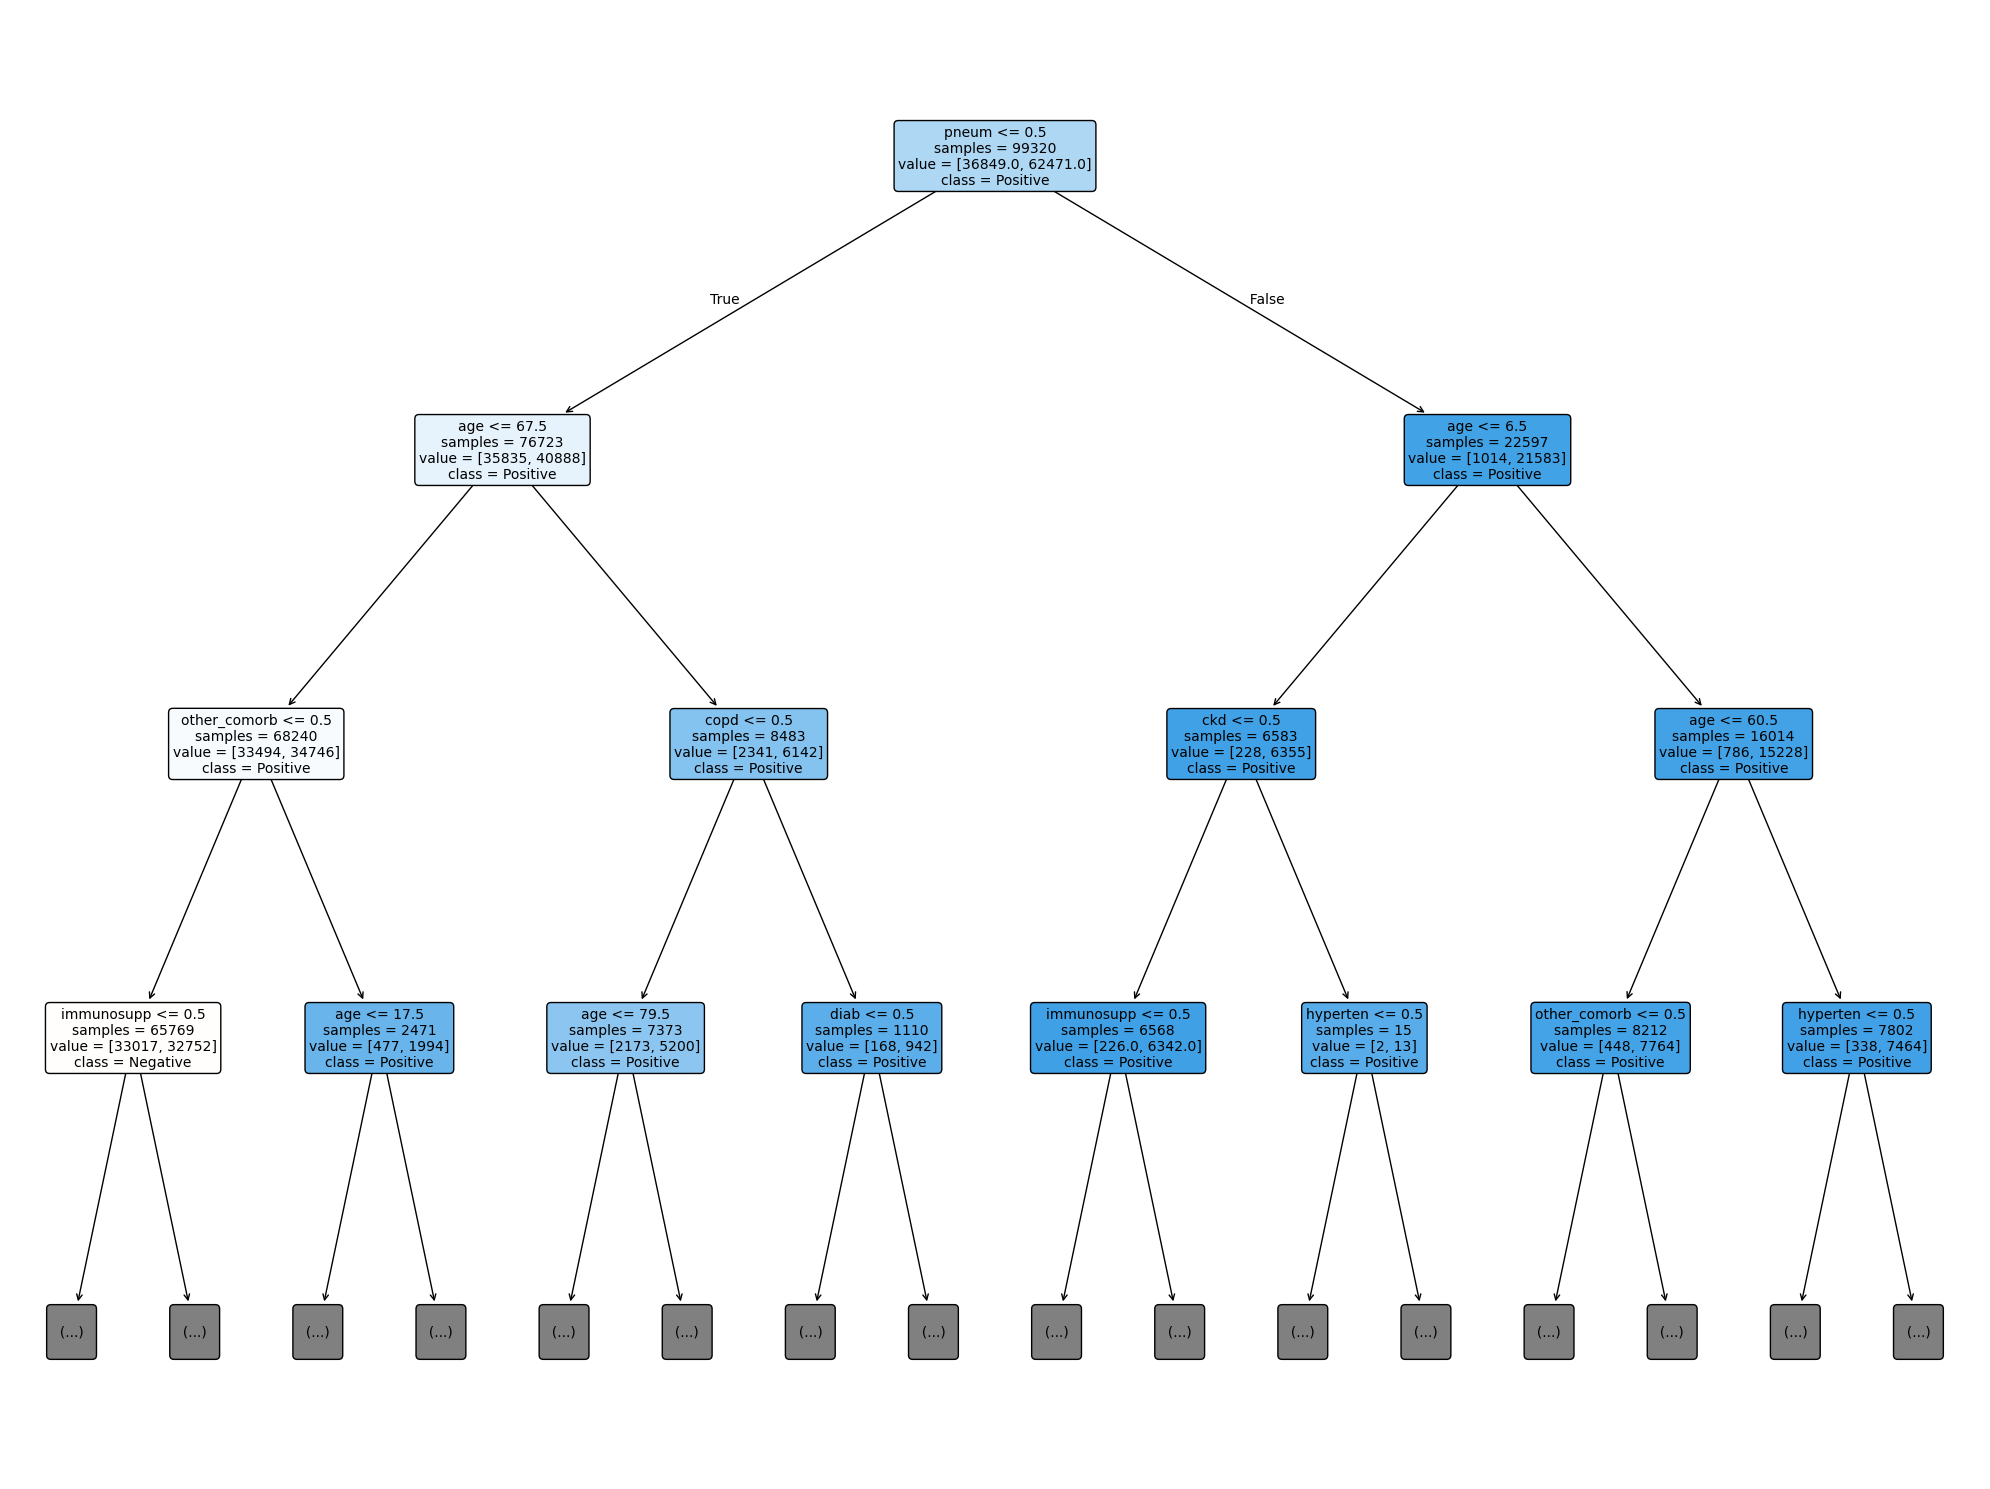

In [68]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

def format_feature_names_out(feature_names):
    abbreviations = {
        'pneumonia': 'pneum',
        'other_comorbidity': 'other_comorb',
        'immunosuppressed': 'immunosupp',
        'hypertension': 'hyperten',
        'contact_with_covid_case': 'covid_contact',
        'chronic_kidney_disease': 'ckd',
        'cardiovascular_disease': 'cvd',
        'diabetes': 'diab',
        'pregnant': 'preg',
        'obesity': 'obes',
        'smoking': 'smoke',
        'asthma': 'asthma',
        'copd': 'copd',
        'age': 'age',
        'sex': 'sex'
    }
    return [abbreviations[name.split("__")[-1].replace("_remapped", "")] for name in feature_names]

plt.figure(figsize=(20, 15))
plot_tree(
    tree_clf["decisiontreeclassifier"], 
    feature_names=format_feature_names_out(
        tree_clf["columntransformer"].get_feature_names_out()),
    class_names=["Negative", "Positive"],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3,
    impurity=False
)
plt.tight_layout()
plt.savefig("DTC_Plot(Depth-3).png")
plt.show()